This notebook works to predict the bitcoin price index using time series analysis.

In [1]:
import pandas as pd
import numpy as np
import datapungi_fed as dpf
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-poster')
%matplotlib inline 

In [2]:
bit = dpf('CBBTCUSD')

In [3]:
bit.columns = ['price']

In the Overview chapeter, we have already seen the original time series of the bitcoin price index which flutuate quite a bit over time. First we will transform this original series to a log scale so it is easier to work with it later. Compare the series before and after the transformation.

In [4]:
bit_log = np.log(bit)

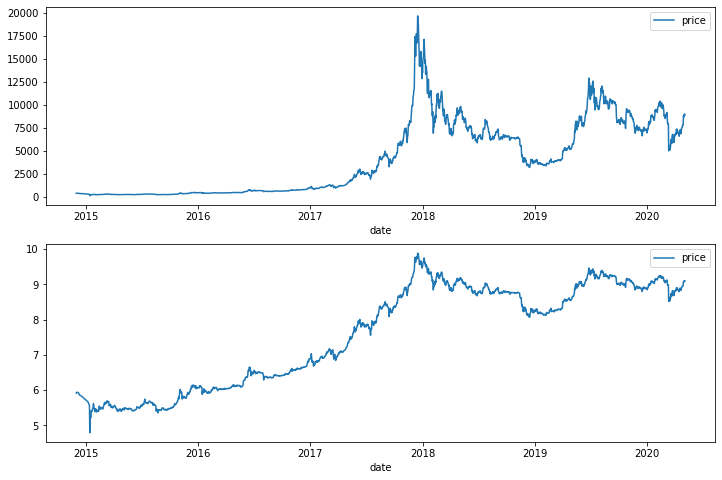

In [212]:
plt.figure(figsize = (12, 8))
plt.subplot(211)
sns.lineplot(data = bit)
plt.subplot(212)
sns.lineplot(data = bit_log)

# ACF

In [5]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from itertools import product
from datetime import datetime

In [7]:
# resample the bit series
bit_week = bit_log.resample('W').last()
bit_month = bit_log.resample('M').last()
bit_q = bit_log.resample('Q').last()
bit_year = bit_log.resample('A').last()

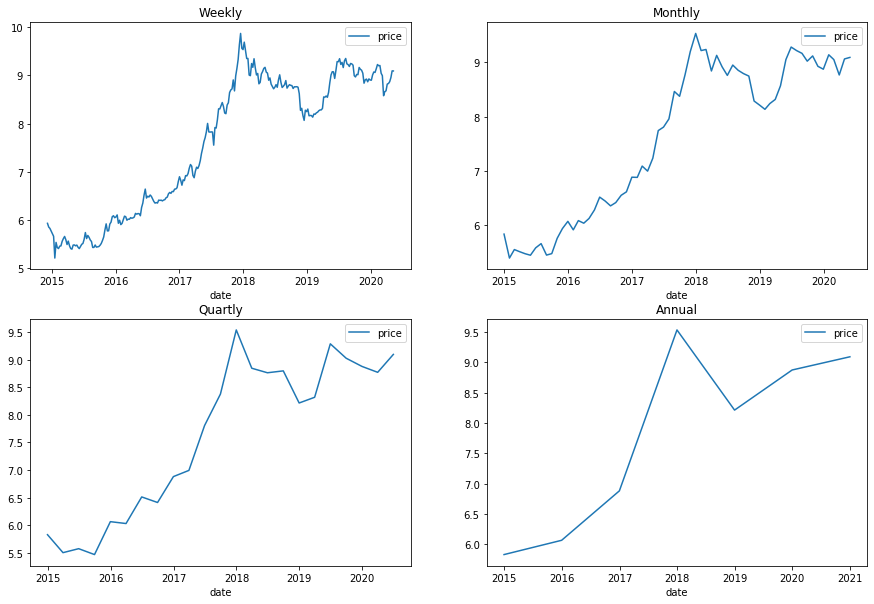

In [216]:
plt.figure(figsize = (15, 10))
plt.subplot(221)
plt.title('Weekly')
sns.lineplot(data = bit_week)
plt.subplot(222)
plt.title('Monthly')
sns.lineplot(data = bit_month)
plt.subplot(223)
plt.title('Quartly')
sns.lineplot(data = bit_q)
plt.subplot(224)
plt.title('Annual')
sns.lineplot(data = bit_year)

We can see after the transformation, the series has an upward trend and probably not stationary. We run the Dickey–Fuller test to verify that.

In [221]:
bit_week = bit_week.fillna(method = 'ffill')

In [222]:
print("Dickey–Fuller test for weekly: p=%f" %sm.tsa.stattools.adfuller(bit_week.price)[1])
print("Dickey–Fuller test for monthly: p=%f" %sm.tsa.stattools.adfuller(bit_month.price)[1])
print("Dickey–Fuller test for quartly: p=%f" %sm.tsa.stattools.adfuller(bit_q.price)[1])
print("Dickey–Fuller test for quartly: p=%f" %sm.tsa.stattools.adfuller(bit_year.price)[1])

Dickey–Fuller test for weekly: p=0.808458
Dickey–Fuller test for monthly: p=0.816150
Dickey–Fuller test for quartly: p=0.776930
Dickey–Fuller test for quartly: p=0.631230


# Seasonal Decomposition 

In [8]:
# populate the monthly difference dataset
diff_month = bit_month - bit_month.shift(1)

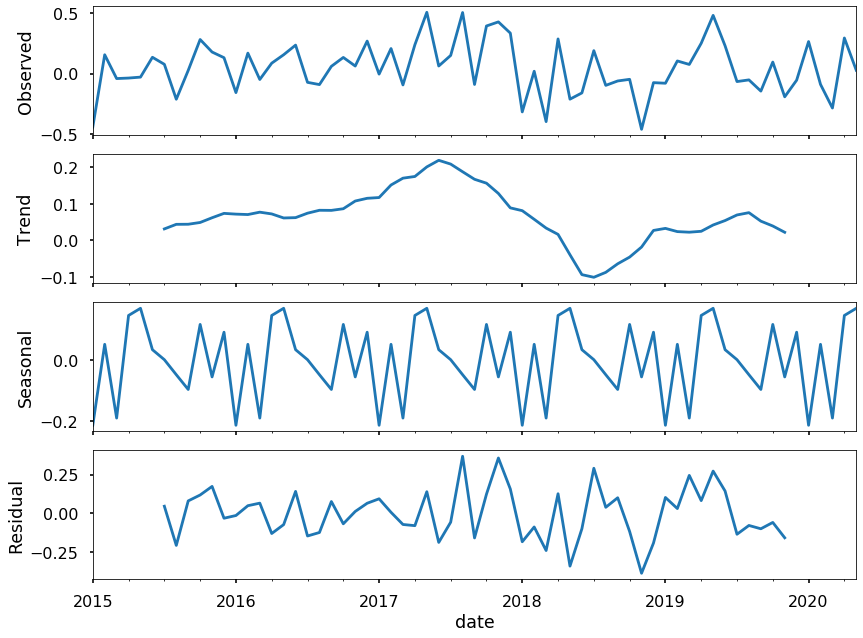

In [257]:
pd.plotting.register_matplotlib_converters()
# STL-decomposition
sm.tsa.seasonal_decompose(diff_month.price[1:]).plot()   
#print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(diff_month.price[1:])[1])
plt.gcf().set_size_inches(12, 9)

In [255]:
item_names = ['Test Statistics', 'p-value', 'Lags Used', 'Number of Obs']
adfuller_result = sm.tsa.stattools.adfuller(diff_month.price[1:], autolag = 'AIC')
for i in range(4):
    print(item_names[i], adfuller_result[i])

Test Statistics -7.83394827667576
p-value 6.186448968830207e-12
Lags Used 0
Number of Obs 64


The montly difference series is stationary.

# Fit the ARIMA model
The ARIMA model would give the best performance.

In [10]:
from statsmodels.tsa.arima_model import ARIMA

In [11]:
model = ARIMA(diff_month[1:], order=(5,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.price   No. Observations:                   64
Model:                 ARIMA(5, 1, 0)   Log Likelihood                   3.600
Method:                       css-mle   S.D. of innovations              0.227
Date:                Tue, 05 May 2020   AIC                              6.800
Time:                        12:07:59   BIC                             21.912
Sample:                    02-28-2015   HQIC                            12.753
                         - 05-31-2020                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0024      0.010      0.254      0.800      -0.016       0.021
ar.L1.D.price    -0.8004      0.127     -6.326      0.000      -1.048      -0.552
ar.L2.D.price    -0.5671      0.161     

Dickey–Fuller test:: p=0.000000


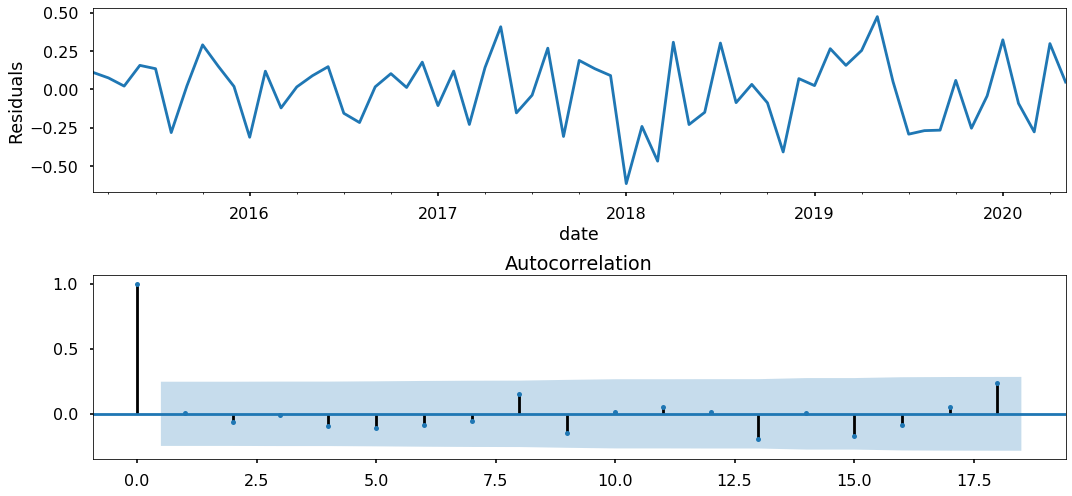

In [278]:
# STL-decomposition
plt.figure(figsize=(15,7))
plt.subplot(211)
model_fit.resid[1:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(model_fit.resid[1:].values.squeeze(), ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(model_fit.resid[1:])[1])

plt.tight_layout()
plt.show()

In [12]:
forecast = model_fit.predict(start=1, end=76)
forecast.name = 'forecast'

In [13]:
diff_month = diff_month.join(forecast, how = 'outer')
diff_month.columns = ['log_diff', 'log_diff_forecast']
bit_month = bit_month.join(diff_month, how = 'outer')
bit_month.columns = ['log_price', 'log_diff', 'log_diff_forecast']

In [56]:
bit_month.head()

,log_price,log_diff,log_diff_forecast,log_price_forecast
2014-12-31,5.828946,NaN,NaN,NaN
2015-01-31,5.386557,-0.442388,NaN,NaN
2015-02-28,5.543575,0.157017,0.002417,5.388974
2015-03-31,5.503297,-0.040278,-0.308866,5.234709
2015-04-30,5.467258,-0.036039,-0.070853,5.432444


In [47]:
bit_month['log_price'].shift(2)

2014-12-31         NaN
2015-01-31         NaN
2015-02-28    5.828946
2015-03-31    5.386557
2015-04-30    5.543575
                ...   
2021-01-31         NaN
2021-02-28         NaN
2021-03-31         NaN
2021-04-30         NaN
2021-05-31         NaN
Freq: M, Name: log_price, Length: 78, dtype: float64

In [54]:
bit_month['log_price_forecast'] = bit_month['log_price'].shift(1) + bit_month['log_diff_forecast']

In [55]:
bit_month.tail(20)

,log_price,log_diff,log_diff_forecast,log_price_forecast
2019-10-31,9.121154,0.096524,0.181932,9.206562
2019-11-30,8.929528,-0.191626,-0.035633,9.085521
2019-12-31,8.875987,-0.053541,0.179987,9.109515
2020-01-31,9.142413,0.266425,-0.003016,8.872971
2020-02-29,9.053930,-0.088483,-0.263750,8.878663
2020-03-31,8.769465,-0.284465,0.080294,9.134223
2020-04-30,9.065580,0.296115,0.282117,9.051582
2020-05-31,9.093839,0.028259,-0.315926,8.749655
2020-06-30,NaN,NaN,-0.027528,9.066311
2020-07-31,NaN,NaN,0.089354,NaN


In [59]:
subset = bit_month.loc['2020-04-30':]

In [102]:
subset

,log_price,log_diff,log_diff_forecast,log_price_forecast
2020-04-30,9.065580,0.296115,0.282117,9.065580
2020-05-31,8.749655,0.028259,-0.315926,8.749655
2020-06-30,8.722126,NaN,-0.027528,8.722126
2020-07-31,8.811481,NaN,0.089354,8.811481
2020-08-31,8.770133,NaN,-0.041348,8.770133
2020-09-30,8.722811,NaN,-0.047322,8.722811
2020-10-31,8.813236,NaN,0.090426,8.813236
2020-11-30,8.775795,NaN,-0.037441,8.775795
2020-12-31,8.770381,NaN,-0.005414,8.770381
2021-01-31,8.789963,NaN,0.019582,8.789963


In [85]:
log_price_forecast = subset['log_price']
log_diff_forecast = subset['log_diff_forecast']

In [100]:
for i in range(1, len(log_price_forecast)):
    log_price_forecast[i] = log_price_forecast[i-1] + log_diff_forecast[i]

In [94]:
log_price_forecast

2020-04-30    9.065580
2020-05-31    8.749655
2020-06-30    8.722126
2020-07-31    8.811481
2020-08-31    8.770133
2020-09-30    8.722811
2020-10-31    8.813236
2020-11-30    8.775795
2020-12-31    8.770381
2021-01-31    8.789963
2021-02-28    8.787337
2021-03-31    8.779481
2021-04-30    8.795671
2021-05-31    8.792501
Freq: M, Name: log_price, dtype: float64

In [101]:
subset['log_price_forecast'] = log_price_forecast

/Users/liwenhuang/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [104]:
bit_month.tail()

,log_price,log_diff,log_diff_forecast,log_price_forecast
2021-01-31,8.789963,NaN,0.019582,8.789963
2021-02-28,8.787337,NaN,-0.002626,8.787337
2021-03-31,8.779481,NaN,-0.007856,8.779481
2021-04-30,8.795671,NaN,0.016189,8.795671
2021-05-31,8.792501,NaN,-0.003169,8.792501


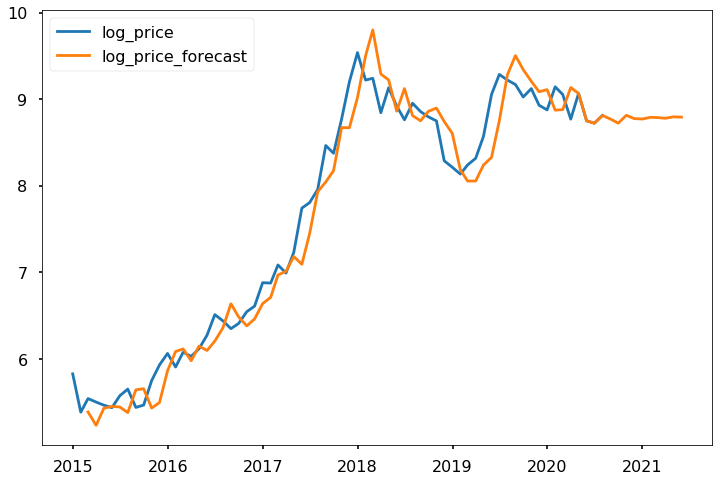

In [107]:
plt.figure(figsize = (12, 8))
sns.lineplot(data = bit_month['log_price'][:-10], label = 'log price')
sns.lineplot(data = bit_month['log_price_forecast'], label = 'log price forecast')

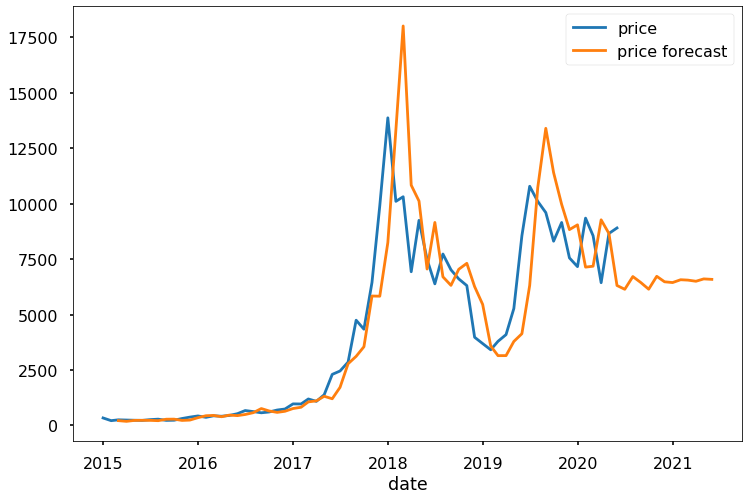

In [114]:
plt.figure(figsize = (12, 8))
sns.lineplot(data = bit.resample('M').last())
sns.lineplot(data = np.exp(bit_month['log_price_forecast']), label = 'price forecast')

In [112]:
bit.resample('M')

# Prophet

In [354]:
from fbprophet import Prophet

In [351]:
# format the data to the requirement of the prophet requirement, ds for datetime and y for price index
bit = bit_log.reset_index()
bit.columns = ['ds', 'y']

In [352]:
bit.head()

,ds,y
0,2014-12-01,5.913503
1,2014-12-02,5.934894
2,2014-12-03,5.934894
3,2014-12-04,5.932510
4,2014-12-06,5.934894


In [353]:
bit['ds'].min(), bit['ds'].max()

(Timestamp('2014-12-01 00:00:00'), Timestamp('2020-05-04 00:00:00'))

In [355]:
# initiate a prophet object to fit the data
m = Prophet()
m.fit(bit)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/liwenhuang/opt/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.



In [363]:
# make a future prediction the next month
future = m.make_future_dataframe(periods = 120)
future.tail() # note that the original data set only has 1941 rows, 30 new rows have been added

,ds
2063,2020-08-28
2064,2020-08-29
2065,2020-08-30
2066,2020-08-31
2067,2020-09-01


In [364]:
forecast = m.predict(future)

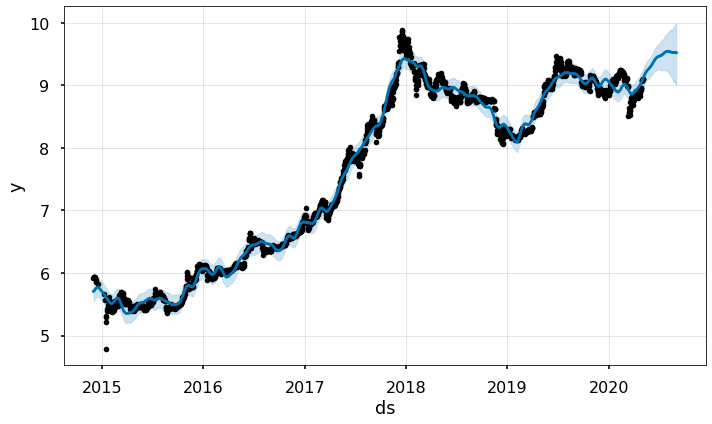

In [365]:
#from fbprophet.plot import add_changepoints_to_plot
fig1 = m.plot(forecast)
#a = add_changepoints_to_plot(fig1.gca(), m, forecast)

In [359]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1973,2020-05-30,9.294639,9.134412,9.444695
1974,2020-05-31,9.299173,9.121152,9.462043
1975,2020-06-01,9.308199,9.133875,9.469123
1976,2020-06-02,9.312870,9.142227,9.468257
1977,2020-06-03,9.315612,9.141649,9.476313


In [360]:
next_month = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)

In [361]:
next_month['ds'] = pd.to_datetime(next_month['ds'])
next_month = next_month.set_index('ds')

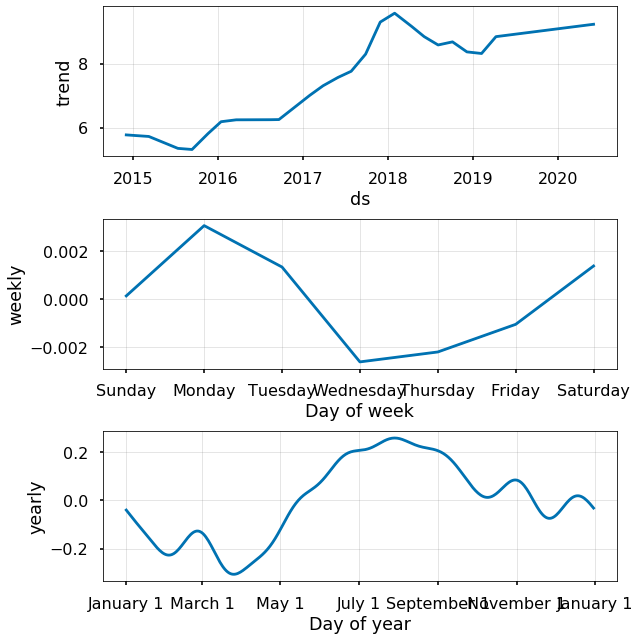

In [362]:
fig2 = m.plot_components(forecast)

reference for this notebook 

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

https://www.kaggle.com/myonin/bitcoin-price-prediction-by-arima

https://www.youtube.com/watch?v=e8Yw4alG16Q
